<table class="m01-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/yy/netsci-course/blob/master/m09-randomgraphs/configuration_model_assignment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a href="https://github.com/yy/netsci-course/blob/master/m09-randomgraphs/configuration_model_assignment.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on Github</a>
  </td>
</table>

# Applying the configuration model

## Why random graphs?
In an early assignment we compared a BA network with an ER graph and saw that the degree distribution and shortest path length were quite different. If all we wanted to know was how the degree distributions were different than an ER graph isn't an unreasonable choice. However, as you learned in the reading and from looking at several different real world graphs you should be aware by now that most graphs don't have a simple poisson degree distribution. So while the ER graph is a simple model, it unfortunately isn't a good null model. 

Null models are often used in hypothesis testing to aid in the acceptance/rejection of some alternative hypothesis. The null, being the default assumption. In network science null models can also be used for statistical hypothesis testing and for determining whether certain graph features are responsible for some characteristic of the graph or some pattern of behavior on the graph (e.g. epidemic models or random walkers). 

The null model should match some of the real graph's topological characteristics but should otherwise be random. The configuration model allows us to hold the degree sequence constant while investigating other graph characteristics.

## Back to dolphins
Lets build a mock hypothesis using the [dolphin social network](http://www-personal.umich.edu/~mejn/netdata/dolphins.zip). My hypothesis is that dolphins have a posh and very exclusive culture. Popular dolphins only hang with other popular dolphins, while the loners are stuck to mingle among themselves. A sad state of affairs, but social life is hard in the pods. How might we test this?

There happens to be a similarity measure called [assortativity](https://en.wikipedia.org/wiki/Assortativity) where nodes of a certain type tend to be connected to nodes of the same type. In networkx there is a function called [degree assortativity](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html?highlight=degree_assortativity_coefficient#networkx.algorithms.assortativity.degree_assortativity_coefficient) which tells us how strongly nodes of similar degree are attached to each other. If the network has high degree assortativity, then low degree nodes will be connected to other low degree nodes, and high degree nodes will be connected to other high degree nodes. Conversely, low degree assortativity (or even disassortativity) would imply no (or negative) relationship. 

Excellent, so we have a measure, but what do we compare our graph too? It wouldn't really be appropriate to compare it to an ER graph because the nodes all have different degrees which are about the same and normally distributed. Instead, we want to compare our dolphin network to a graph with the same degree distribution, and that is where the configuration model comes in.

## Testing the dolphin hypothesis
We are going to do a rough test for our hypothesis by calculating the z-score for our dolphin network's degree assortativity coefficient. We will do this by generating a bunch of configuration models based on the dolphin degree sequence and calculating the assortativity coefficient for those null graphs. We can then compare our real network with the null model. If our z-score is high then it is unlikely that the dolphin network's assortativity can be accounted for by just the degree-sequence of a random graph, which means something more interesting is at work.

Lets carry out this experiment:

In [1]:
# We should load networkx and scipy (which has statistical tools)
import networkx as nx
import scipy.stats as stats

# Lets load the dolphin social network
dolphin_net = nx.read_gml("dolphins/dolphins.gml")

# Often networkx will auto-load graphs as MultiGraphs
# I know this network is simple, so I will make sure it is of graph type Graph.
# Don't do this if your graph is directed. Directed graphs are of type DiGraph
dolphin_net = nx.Graph(dolphin_net)
print(type(dolphin_net).__name__)

Graph


Now that the graph is loaded in lets calculate the degree assortativity:

In [2]:
real_assortativity = nx.degree_assortativity_coefficient(dolphin_net)
print(real_assortativity)

-0.04359402821531255


Interesting! So it appears that the network is disassortative, so it seems like our hypothesis about the dolphins is falling appart, but we still need to compare it to a null model in order to determine whether there is anything of interest to be pursued here.

Networkx has a [configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration_model) function that can be used to generate our null models. We can use it by passing it a degree sequence, which we will do using the dolphin network:

In [3]:
# nx.degree returns a dictionary, but all we want is a list of the
# degrees. We can get this by getting the dictionary values and
# converting those values to a list.
dolphin_degree_sequence = list(dict(nx.degree(dolphin_net)).values())

# We need to generate enough null graphs to make a reasonable assessment of the null distribution
model_assortativity = []
for i in range(1000):
    # Use the configuration model to create a null graph
    null_graph = nx.configuration_model(dolphin_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    null_graph = nx.Graph(null_graph) # removes parallel edges
    null_graph.remove_edges_from(nx.selfloop_edges(null_graph)) # removes self-loops
    
    # Calculate the model's assortativity and add it to the list
    model_assortativity.append(nx.degree_assortativity_coefficient(null_graph))

Now we can calculate the z-scores using scipy's [zscore](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) function. It will print out the z-scores for all the elements of the distribution. If we assume that the dolphin network came from the null distribution then we can calculate the z-score for the dolphin network:

In [4]:
# Prepend the real assortativity to the model list and have scipy calculate the zscores
zscores = stats.zscore([real_assortativity] + model_assortativity)

# Just print out the first score which corresponds to the real network
print(zscores[0])

0.023637963141310583


A z-score corresponds to how many standard deviations out from the mean the sample is. A score of +1 would be one standard deviation above the mean. Since the score is close to zero we can safely conclude that the disassortativity we observed in the dolphin network is explainable entirely from the degree sequence and no other special properties of the network.

However, this doesn't mean there aren't low-level features hidden in the network. The degree assortativity score is an aggregative measure, and it can obfuscate local deviations from assortativity that are non-random. There is also a score for the local degree assortativity, but we will not pursue that further here.

Now that we have a distribution of null assortativities we can also visualize the distribution and plot our dolphin network's assortativity along with it:

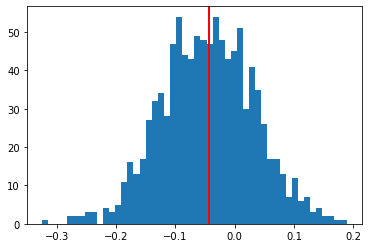

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Use the histogram function to plot the distribution of assortativity coefficients
plt.hist(model_assortativity, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(real_assortativity, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

And there we have it! We have fair reason to conclude that not only is the hypothesis wrong but the surprising disassortativity we found really wasn't anything special after all. [note: reference for [`axvline`](http://matplotlib.org/api/pyplot_api.html?highlight=axvline#matplotlib.pyplot.axvline) in matplotlib]

# Assignment

1. Pick a graph of your choosing. You can use the graphs you are using for your project or any other real-world graph. Here are a couple places you can find some: [pajek datasets](http://vlado.fmf.uni-lj.si/pub/networks/data/), [Newman's datasets](http://www-personal.umich.edu/~mejn/netdata/). [note: if you use directed graphs makes sure you use the corresponding function [`directed_configuration_model`](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.directed_configuration_model.html?highlight=configuration_model#networkx.generators.degree_seq.directed_configuration_model)]

2. Construct two simple hypotheses around two different measures that you can calculate from the graph. Here is a [list of algorithms that networkx has](https://networkx.github.io/documentation/stable/reference/algorithms/index.html). You aren't limited by measures networkx can calculate. However, do not use a measure that depends entirely on the degree sequence. For instance, it would be silly to compare average degree to the random networks generated by the configuration model because it uses the same degree sequence and so will have the same average degree.

3. Carry out a simple hypothesis test for both hypotheses. It can be similar to what I showed here. You are welcome to carry it out in a more robust manner, but the focus of this assignment is getting a hang of using configuration models as null models. Here is a link to [Statistics for Hackers](https://speakerd.s3.amazonaws.com/presentations/7e68b43159d646cf81eda9e1bded8213/Statistics_for_Hackers_-_PyCon2016.pdf). It has a nice little python tutorial for how you can carry out hypothesis testing without all the hard math. Even if you don't use it for this assignment I highly recommend checking it out.

4. Provide quantitative analysis and a graphical illustration of your results. It should be clear that your hypothesis was validated/invalidated/inconclusive.

5. Answer the following questions:
  * What graph are you using?
  * What are you hypotheses?
  * What measures will you be using to test your hypotheses? How do these measures accomplish this?
  * Explain your results. Were they surprising? Did they confirm or reject your hypotheses?
  * From these tests, what have you learned about the structure of the network you were investigating?

6. Once you are complete submit your Jupyter notebook to Canvas.

In [8]:
# We should load networkx and scipy (which has statistical tools)
import networkx as nx
import scipy.stats as stats

# Lets load the yeast PPI network
yeast_net = nx.read_pajek("yeast/Yeast.paj")

# Often networkx will auto-load graphs as MultiGraphs
# I know this network is simple, so I will make sure it is of graph type Graph.
# Don't do this if your graph is directed. Directed graphs are of type DiGraph
yeast_net = nx.Graph(yeast_net)
print(type(yeast_net).__name__)

Graph


# Background
Interaction detection methods have led to the discovery of thousands of interactions between proteins, and discerning relevance within large-scale data sets is important to present-day biology. 

Lets build a mock hypothesis using the [yeast network](http://vlado.fmf.uni-lj.si/pub/networks/data/bio/Yeast/Yeast.htm). A modular pattern, also called community structure, is ubiquitous in biological networks. I would like to generate null models to serve as random controls when investigating the impact of complex network features beyond the byproduct of degree and modularity in empirical biological networks. my work below allows for the systematic study of the presence of community structure and its impact on network function and dynamics.

I would like to get an insight into a yeats PPI network's functional components and the impact of local structures on dynamics at a global scale.


## Hypothesis 1:
Reference: https://www.biorxiv.org/content/10.1101/001545v1.full.pdf
"Disassortative interactions in protein-protein interaction networks are known to reduce interferences between functional modules and thus increase the overall robustness of the network to deleterious perturbation, while also allowing for functions to be performed concurrently." 

My hypothesis is that disassortative interactions may be selected for in the evolution of biological networks such as the yeast PPI.

As mentioned above, the similarity measure called assortativity where nodes of a certain type tend to be connected to nodes of the same type. I will use the function called degree assortativity which tells us how strongly nodes of similar degree are attached to each other. If the network has high degree assortativity, then low degree nodes will be connected to other low degree nodes, and high degree nodes will be connected to other high degree nodes. Conversely, low degree assortativity (or even disassortativity) would imply no (or negative) relationship.

I will create a configuration model so that I am comparing the yeast PPI network to a graph with the same degree distribution.

 
# Testing the Yeast hypothesis (1)

We are going to do a rough test for our hypothesis by calculating the z-score for our yeast PPI network's degree assortativity coefficient. We will do this by generating a bunch of configuration models based on the yeast degree sequence and calculating the assortativity coefficient for those null graphs. We can then compare our real network with the null model. If our z-score is high then it is unlikely that the yeast PPI network's assortativity can be accounted for by just the degree-sequence of a random graph, which means something more interesting is at work.

Lets carry out this experiment:

In [11]:
yeast_real_assortativity = nx.degree_assortativity_coefficient(yeast_net)
print(yeast_real_assortativity)

-0.08389573992948601


Interesting again! It appears that the yeast PPI network is disassortative, so it seems like our hypothesis might be proven correct, but we still need to compare it to a null model in order to determine whether there is anything of interest to be pursued here.

In [10]:
# nx.degree returns a dictionary, but all we want is a list of the
# degrees. We can get this by getting the dictionary values and
# converting those values to a list.
yeast_degree_sequence = list(dict(nx.degree(yeast_net)).values())

# We need to generate enough null graphs to make a reasonable assessment of the null distribution
yeast_model_assortativity = []
for i in range(1000):
    # Use the configuration model to create a null graph
    yeast_null_graph = nx.configuration_model(yeast_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    yeast_null_graph = nx.Graph(yeast_null_graph) # removes parallel edges
    yeast_null_graph.remove_edges_from(nx.selfloop_edges(yeast_null_graph)) # removes self-loops
    
    # Calculate the model's assortativity and add it to the list
    yeast_model_assortativity.append(nx.degree_assortativity_coefficient(yeast_null_graph))

Now we can calculate the z-scores using scipy's zscore function. It will print out the z-scores for all the elements of the distribution. If we assume that the yeast PPI network came from the null distribution then we can calculate the z-score for the yeast PPI network:

In [12]:
# Prepend the real assortativity to the model list and have scipy calculate the zscores
hypa_zscores = stats.zscore([yeast_real_assortativity] + yeast_model_assortativity)

# Just print out the first score which corresponds to the real network
print(hypa_zscores[0])

-6.502436566075931


The z-score is far from zero, we can not conclude that the disassortativity we observed in the yeast network is explainable entirely from the degree sequence and some other special properties of the network are at work.

This means low-level features are hidden in the network. The degree assortativity score is an aggregative measure, and it can obfuscate local deviations from assortativity that are non-random. 

Now that we have a distribution of null assortativities we can also visualize the distribution and plot our yeast PPI network's assortativity along with it:

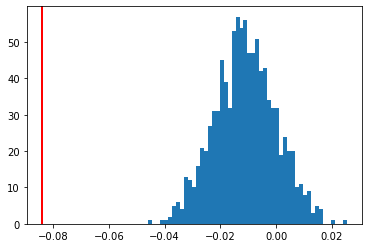

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# Use the histogram function to plot the distribution of assortativity coefficients
plt.hist(yeast_model_assortativity, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(yeast_real_assortativity, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

To find out what other factors might be at play here in the yeast PPI network which are responsible for the disassortavity in the network, we will calculate the clustering coefficient of the graph.

In [15]:
yeast_real_clustering = nx.average_clustering(yeast_net)
print(yeast_real_clustering)

0.12978730838048055


Looks good! It appears that the yeast PPI network clustering coefficient might have some role to play here. So it seems like our hypothesis about the yeast PPI is becoming more supported. Let us compare it to a null model in order to determine what this value of clustering coefficient means for the yeast PPI network.

In [14]:

# We need to generate enough null graphs to make a reasonable assessment of the null distribution
yeast_model_clustering_coefficient = []
for i in range(1000):
    # Use the configuration model to create a null graph
    yeast_null_graph = nx.configuration_model(yeast_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    yeast_null_graph = nx.Graph(yeast_null_graph) # removes parallel edges
    yeast_null_graph.remove_edges_from(nx.selfloop_edges(yeast_null_graph)) # removes self-loops
    
    # Calculate the model's clustering coefficient and add it to the list
    yeast_model_clustering_coefficient.append(nx.average_clustering(yeast_null_graph))

Like before, now we can calculate the z-scores using scipy's zscore function. It will print out the z-scores for all the elements of the distribution. If we assume that the yeast PPI network came from the null distribution then we can calculate the z-score for the yeast PPI network:

In [16]:
# Prepend the real clustering coefficient to the model list and have scipy calculate the zscores
hypa1_zscores = stats.zscore([yeast_real_clustering] + yeast_model_clustering_coefficient)

# Just print out the first score which corresponds to the real network
print(hypa1_zscores[0])

29.796760435793583


Now that we have a distribution of null graph clustering coefficients we can also visualize the distribution and plot our yeast PPI network's clustering coefficient along with it:

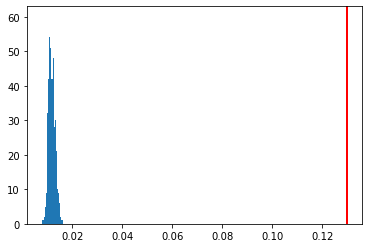

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# Use the histogram function to plot the distribution of assortativity coefficients
plt.hist(yeast_model_clustering_coefficient, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(yeast_real_clustering, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

### Results and Conclusion:
The hypothesis is proven right as I expected and there is some disassortavity in the yeast PPI network. The results were surpring because I did not think there are other low level features which might be at work. 

From these tests, I learned two things about the structure of the network:
* There is disassortivity in yeast PPI networks.
This means that these protein-protein interactions reduce interferences between functional modules and thus increase the overall robustness of the network to deleterious perturbation

* It is also evident that the yeast protein network has a higher value of clustering coefficient than the expected value predicted by the configuration model. 
A high value of clustering coefficient indicates that there are several alternate interaction paths between two proteins, making the system more robust to perturbation

These results prove that my first hypothesis is correct.

## Hypothesis 2:

Reference: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0039052
"Many PPI’s are driven by a simple geometric compatibility between the surfaces of the proteins. The simplest example is the case of PPI’s between flat, hydrophobic surfaces, a type of interaction which is very common. These PPI’s have a simple planar interface, and the binding sites on the individual proteins are geometrically quite similar to one another."

My hypothesis is that due to these similar-surface interactions in yeast PPI network, if protein A can bind to proteins B and C, then there is a greater-than-random chance that B and C will interact with each other.

There is a measure called transivity where if A binds B, and A binds C, then B binds C. The number of triangles in the yeast PPI network should correlate roughly with transitivity. I will use the transivity algorithm provided in networkx.

I will create a configuration model so that I am comparing the yeast PPI network to a graph with the same degree distribution.


# Testing the Yeast hypothesis (2)

We are going to do a rough test for our hypothesis by calculating the z-score for our yeast PPI network's graph transitivity. We will do this by generating a bunch of configuration models based on the yeast degree sequence and calculating the transivity for those null graphs. We can then compare our real network with the null model. If our z-score is high then it is unlikely that the yeast network's transivity can be accounted for by just the degree/ edge-sequence of a random graph, which means something more interesting is at work.

Lets carry out this experiment:

In [19]:
yeast_real_transitivity = nx.transitivity(yeast_net)
print(yeast_real_transitivity)

0.10231290939655673


Interesting! So it appears that the network is transitive, so it seems like our second hypothesis about the yeast PPI netwokr is going to be proven correct, but we still need to compare it to a null model in order to determine whether there is anything of interest to be pursued here. The transitivity value is not very high/ is low which means that there are forces at work in the network that shy away from the creation of triangles.

Networkx has a configuration model function that can be used to generate our null models. We can use it by passing it a degree sequence, which we will do using the yeast PPI network:

In [20]:
# We need to generate enough null graphs to make a reasonable assessment of the null distribution
yeast_model_transitivity = []
for i in range(1000):
    # Use the configuration model to create a null graph
    yeast_null_graph = nx.configuration_model(yeast_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    yeast_null_graph = nx.Graph(yeast_null_graph) # removes parallel edges
    yeast_null_graph.remove_edges_from(nx.selfloop_edges(yeast_null_graph)) # removes self-loops
    
    # Calculate the model's clustering coefficient and add it to the list
    yeast_model_transitivity.append(nx.transitivity(yeast_null_graph))

Like before, now we can calculate the z-scores using scipy's zscore function. It will print out the z-scores for all the elements of the distribution. If we assume that the yeast PPI network came from the null distribution then we can calculate the z-score for the yeast PPI network:

In [21]:
# Prepend the real transitivity coefficient to the model list and have scipy calculate the zscores
hypa2_zscores = stats.zscore([yeast_real_transitivity] + yeast_model_transitivity)

# Just print out the first score which corresponds to the real network
print(hypa2_zscores[0])

30.429655202666247


The z-score is way far from zero, we can not conclude that the transitivity observed in the yeast network is explainable entirely from the degree sequence and some other special properties of the network are at work.

This means low-level features are hidden in the network. The transitivity score is an aggregative measure, and it can obfuscate local deviations from transitivity that are non-random.

Now that we have a distribution of null transitivities we can also visualize the distribution and plot our yeast PPI network's transitivity along with it:

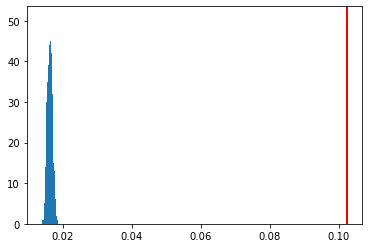

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

# Use the histogram function to plot the distribution of assortativity coefficients
plt.hist(yeast_model_transitivity, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(yeast_real_transitivity, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

It is evident that the yeast protein network has a higher value of transitivity than the expected value predicted by the configuration model. A high value of transitivity indicates that there are several alternate interaction paths between two proteins. The transitivity measures the density of loops of length three (triangles) in a network. 

In [23]:
yeast_real_number_of_triangles = sum(nx.triangles(yeast_net).values()) / 3
print(yeast_real_number_of_triangles)

3530.0


We will now compare the number of triangles in the real network with the configuration model.

In [24]:
# We need to generate enough null graphs to make a reasonable assessment of the null distribution
yeast_model_triangles = []
for i in range(1000):
    # Use the configuration model to create a null graph
    yeast_null_graph = nx.configuration_model(yeast_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    yeast_null_graph = nx.Graph(yeast_null_graph) # removes parallel edges
    yeast_null_graph.remove_edges_from(nx.selfloop_edges(yeast_null_graph)) # removes self-loops
    
    # Calculate the model's clustering coefficient and add it to the list
    yeast_model_triangles.append(sum(nx.triangles(yeast_null_graph).values()) / 3)

Like before, now we can calculate the z-scores using scipy's zscore function. It will print out the z-scores for all the elements of the distribution. If we assume that the yeast PPI network came from the null distribution then we can calculate the z-score for the yeast PPI network:

In [25]:
# Prepend the real transitivity coefficient to the model list and have scipy calculate the zscores
hypa2b_zscores = stats.zscore([yeast_real_number_of_triangles] + yeast_model_triangles)

# Just print out the first score which corresponds to the real network
print(hypa2b_zscores[0])

30.226895800323323


The z-score is way far from zero, we can not conclude that the transitivity/ number of triangles observed in the yeast network is explainable entirely from the degree sequence and some other special properties of the network are at work. Our initial prediction is strengthened again by these results and that low-level features are hidden in the network.

Now that we have a distribution of number of triangles in null model we can also visualize the distribution and plot our yeast PPI network's number of triangles along with it:

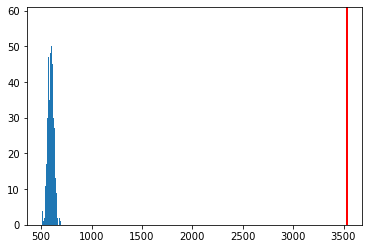

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

# Use the histogram function to plot the distribution of assortativity coefficients
plt.hist(yeast_model_triangles, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(yeast_real_number_of_triangles, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

Conclusion: As discussed below, the number of triangles, is about 7 times higher in real PPI networks than in an equally-dense random graph. This suggests that transitivity is quite common in PPI networks. For later work, we can also look at densities of other small groups of nodes, or motifs. It is possible that these motifs are playing the role of functional circuit elements.

Our second hypothesis is also proven correct. As predicted, the number of triangles in the yeast PPI network correlated roughly with transitivity.